In [1]:
import sys
import os
import glob
sys.path.append('../..')

from model import processing

prefix = 'DOTBUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
result = glob.glob(prefix + '-' + tick + '-' + '*.{}'.format(extension))
os.chdir('..')

# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(result)
# input_filename = 'input/test.csv'
output_filename = 'output/' + prefix + "-" + tick + "-output.csv"

# price_data = processing.import_binance_prices(path, result)[::12]
input_filename = 'DOT_crash.csv'
price_data = processing.import_prices(path, input_filename)


final_price = price_data[-1]
price_data.extend([final_price] * 100)
price_list = [{'DOT':data.price} for data in price_data]
print(price_list[0:10])

# we want about .000002 * TVL in volume every block

['DOTBUSD-1s-2022-11-20.csv']
[{'DOT': 34.442}, {'DOT': 34.442}, {'DOT': 34.442}, {'DOT': 34.447}, {'DOT': 34.447}, {'DOT': 34.447}, {'DOT': 34.447}, {'DOT': 34.447}, {'DOT': 34.439}, {'DOT': 34.424}]


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamic_asset_fee, dynamic_lrna_fee, dynamicmult_lrna_fee, dynamicmult_asset_fee, dynamicadd_asset_fee, dynamicadd_lrna_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.10},
    'AUSD': {'usd price': 1, 'weight': 0.10},
    'ETH': {'usd price': 1, 'weight': 0.60},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.10}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            oracles={'fee_raise': 300},  # , 'fee_lower': 7200},
            lrna_fee=dynamicadd_lrna_fee(
                minimum=0.0005,
                amplification=1/5,
                raise_oracle_name='fee_raise',
                decay=0.000002,
                fee_max=0.1,
            ),
            asset_fee=dynamicadd_asset_fee(
                minimum=0.0025,
                amplification=1,
                raise_oracle_name='fee_raise',
                decay=0.00001,
                fee_max=0.4,
            ),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_attempts=3,
                # skip_assets=['HDX']
            )
        ),
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000},
            trade_strategy=back_and_forth(
                pool_id='omnipool',
                percentage=0.00005
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        ),
        'LPDOT': Agent(
            holdings={'DOT': liquidity['DOT'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPAUSD': Agent(
            holdings={'AUSD': liquidity['AUSD'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPETH': Agent(
            holdings={'ETH': liquidity['ETH'] / 10},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    # evolve_function=fluctuate_prices(volatility={tkn: 1 for tkn in assets}),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # save_data = {
    #     'prices': pu.Datastream(asset='all'),
    #     # 'pool_val': pu.Datastream(pool='omnipool', prop='pool_val'),
    #     'asset_fee': pu.Datastream(pool='omnipool', prop='asset_fee', key='all'),
    #     'lrna_fee': pu.Datastream(pool='omnipool', prop='lrna_fee', key='all'),
    #     'LP returns': pu.Datastream(agent='LP', prop='cash_out')
    # }
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 21699 time steps
Starting simulation...
1
1
3
3
3
4
4
3
3
2
5
4
4
3
2
5
3
4
5
2
5
5
5
3
3
5
4
4
3
4
2
2
5
5
5
5
4
4
4
5
3
3
3
2
5
4
3
5
3
2
5
3
3
4
4
5
3
4
4
3
2
3
4
4
5
3
4
4
4
2
4
4
2
2
5
2
5
2
2
4
2
2
2
4
3
5
4
2
2
4
4
4
1
2
4
5
1
1
3
2
2
2
5
4
5
3
3
2
2
3
2
3
4
5
5
3
3
2
5
2
2
5
2
3
4
4
4
3
4
2
5
4
4
3
4
3
5
3
3
5
2
5
2
2
4
4
3
4
2
4
3
5
2
2
2
4
5
2
2
1
2
1
3
2
3
5
3
3
3
2
4
2
5
4
5
3
3
5
4
5
5
3
3
3
5
2
2
2
3
4
2
5
2
3
3
2
5
4
3
3
4
3
5
3
5
4
4
5
4
4
5
5
3
2
3
2
5
4
3
3
2
2
2
4
2
2
2
4
2
4
4
4
2
3
3
5
3
2
3
3
2
2
4
4
5
2
3
5
3
3
2
4
5
2
4
3
2
5
5
3
4
4
5
5
5
4
4
5
4
3
3
5
4
4
2
4
3
2
4
2
5
5
4
4
2
3
3
4
3
1
4
4
2
2
2
4
3
2
2
3
2
3
3
4
3
4
2
5
3
2
4
4
2
2
5
3
3
4
4
3
3
5
2
4
4
2
3
5
2
5
2
3
4
2
3
4
1
4
2
2
2
4
3
4
2
2
2
1
2
4
1
1
3
2
3
2
5
4
2
3
2
1
2
3
4
3
3
2
4
2
3
4
2
3
5
2
3
3
1
1
2
3
3
3
2
2
3
3
3
3
2
4
4
3
2
3
2
3
3
4
4
5
5
5
5
5
2
2
5
4
5
4
4
4
4
4
5
4
2
2
5
2
5
4
2
3
3
4
2
3
2
4
2
2
2
2
2
2
3
5
2
2
3
1
2
1
2
4
2
2
2
3
2
2
2
4
4
4
2
2
2
2
2
3
3
3
1
4
1
3
2
2
3
2

'HDX'
'AUSD'
'ETH'
'DOT'


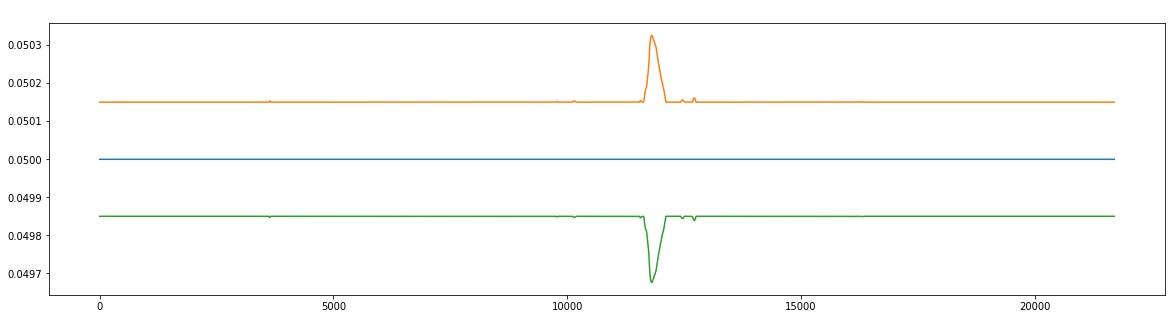

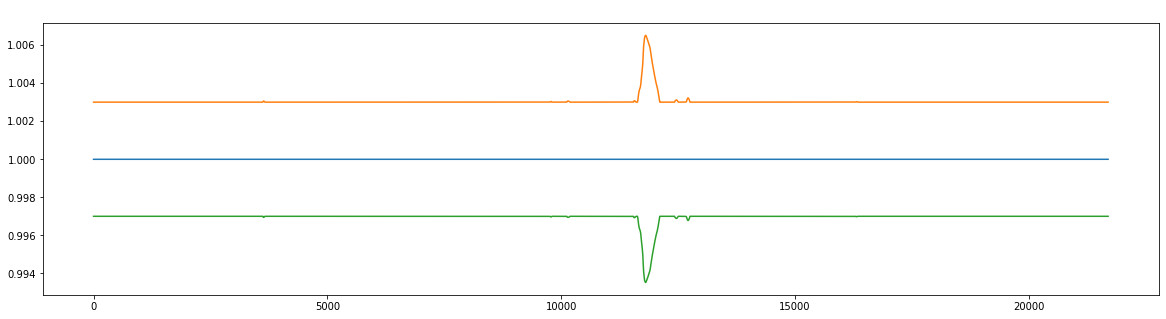

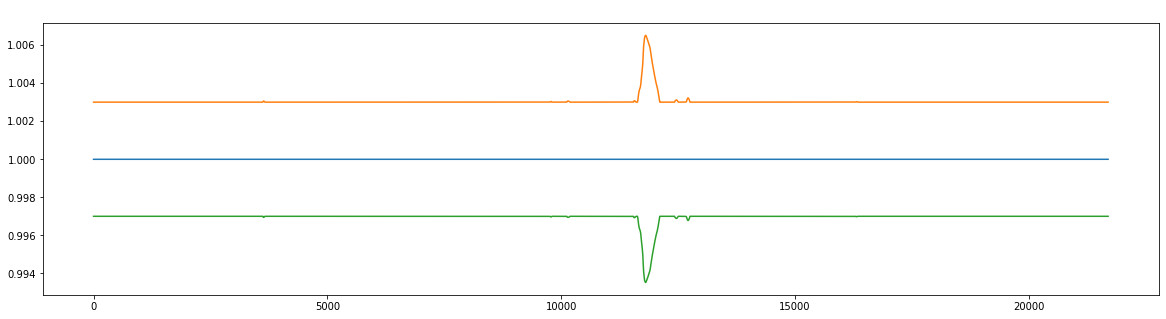

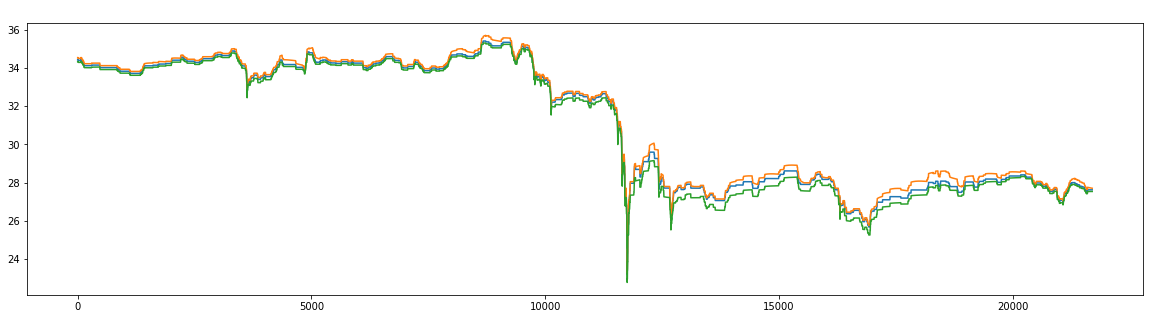

In [3]:
usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events)
USD_lrna_fees = [None]*len(events)
for i in range(len(events)):
    op = events[i]['state'].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    if tkn == 'USD':
        continue
    prices = [None]*len(events)
    last_fees = [None]*len(events)
    last_lrna_fees = [None]*len(events)
    buy_prices = [None]*len(events)
    sell_prices = [None]*len(events)
    for i in range(len(events)):
        op = events[i]['state'].pools['omnipool']
        prices[i] = op.usd_price(tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    pprint(tkn)
    pu.plot(sell_prices, subplot=ax)


:::FEES:::


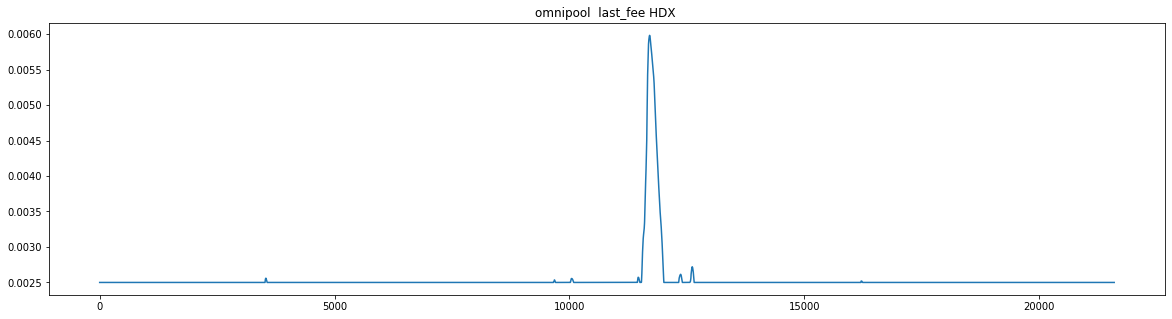

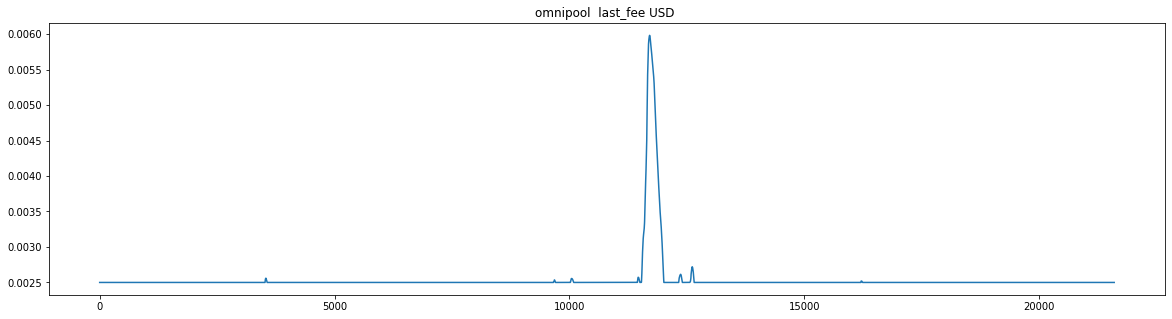

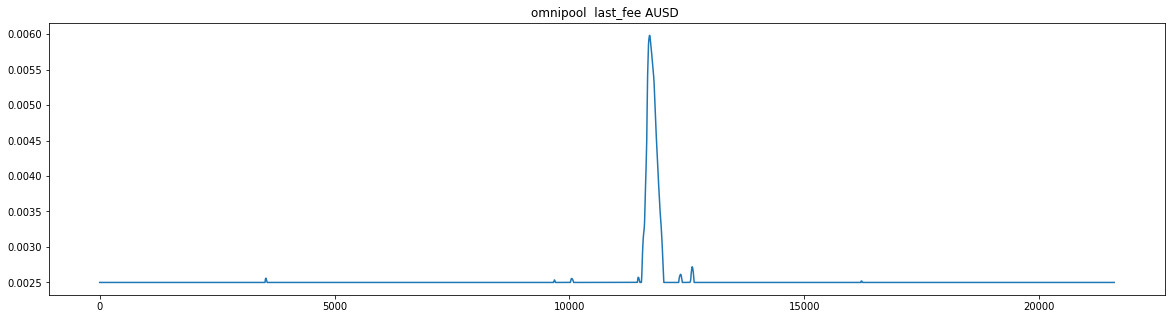

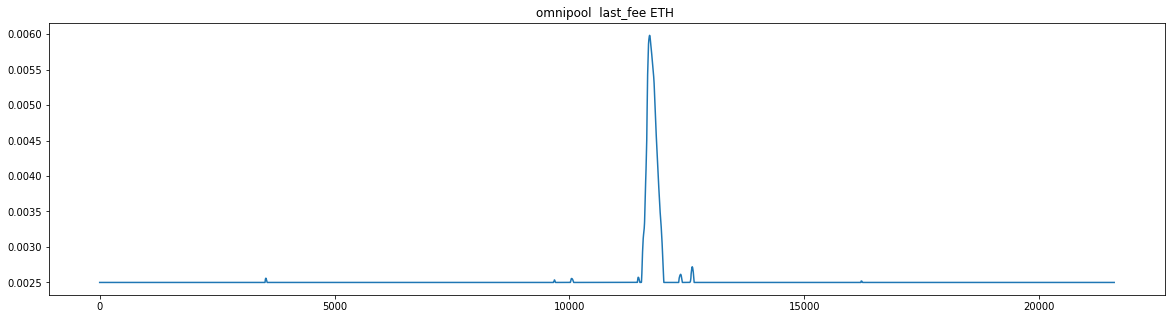

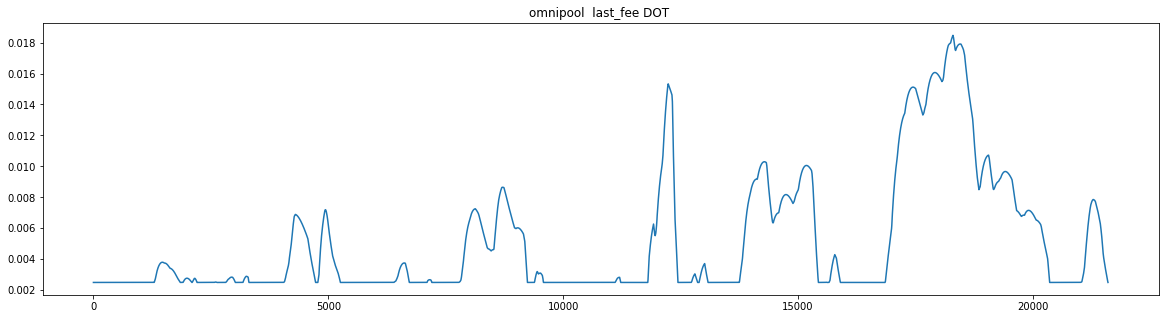

In [4]:
# print(events[0])
# dynamic_mult = [events[i]['state'].pools['omnipool'].last_mult for i in range(len(events))]
# plt.plot(range(len(dynamic_mult)), dynamic_mult)
# print(initial_state.pools['omnipool'].asset_list)
print(":::FEES:::")
# asset_fee = pu.get_datastream(events, pool='omnipool', prop='asset_fee', key='all')  # {tkn: [event['asset_fee'][tkn] for event in events[10:]] for tkn in assets}
# lrna_fee = pu.get_datastream(events, pool='omnipool', prop='lrna_fee', key='all')  # {tkn: [event['lrna_fee'][tkn] for event in events[10:]] for tkn in assets}
# print(lrna_fee['HDX'][1])
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    # plt.figure(figsize=(20, 5))
    # ax = pu.plot(events[10:], pool='omnipool', prop='last_lrna_fee', key=tkn)
    pu.plot(events[100:], pool='omnipool', prop='last_fee', key=tkn)
    # plt.title(tkn)

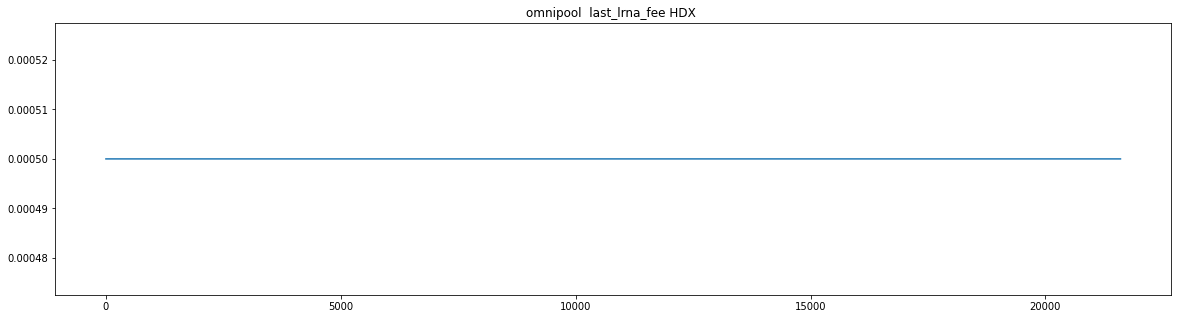

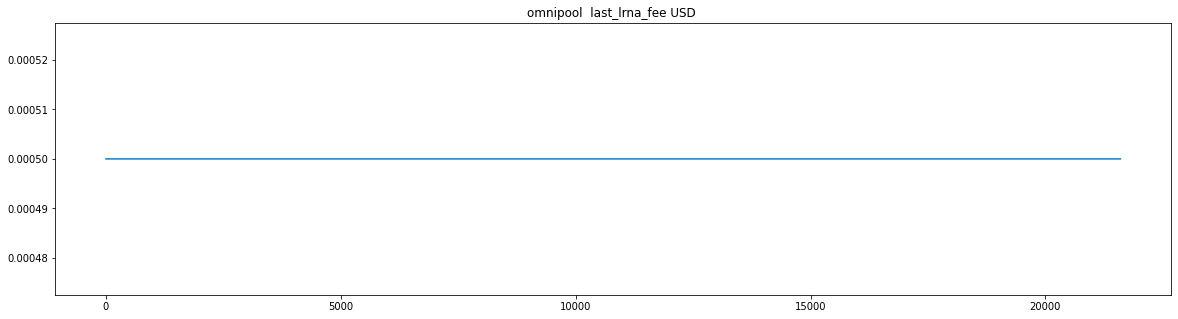

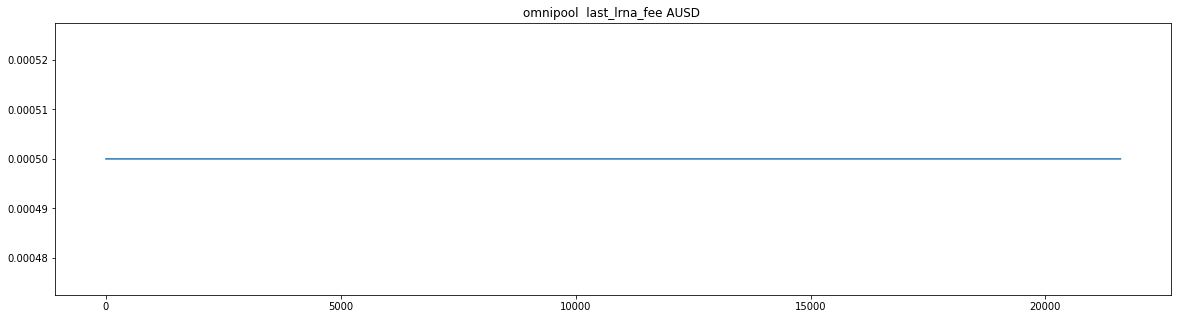

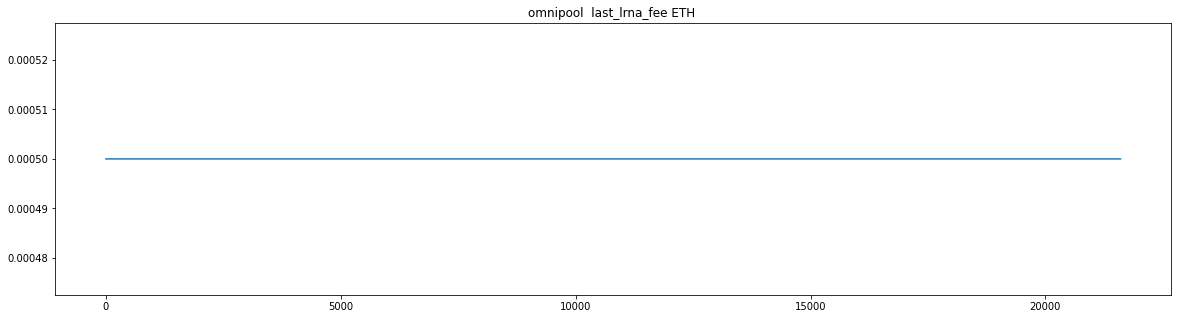

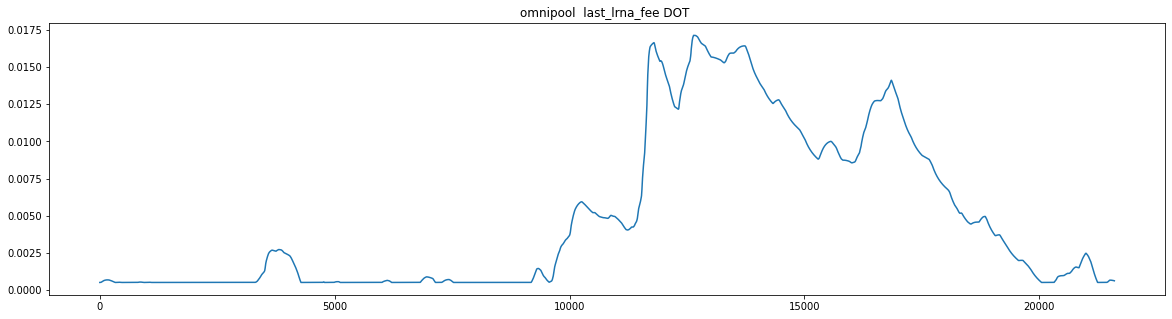

In [5]:
for tkn in initial_state.pools['omnipool'].asset_list:
    pu.plot(events[100:], pool='omnipool', prop='last_lrna_fee', key=tkn)

In [6]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0005
basic_state.pools['omnipool'].asset_fee = 0.0025

events2 = run.run(basic_state, time_steps=time_steps)
# events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1]['state'].agents['Arbitrageur']

Starting simulation...
1
1
3
3
3
4
4
3
3
2
5
4
4
3
2
5
3
4
5
2
5
5
5
3
3
5
4
4
3
4
2
2
4
3
4
4
4
2
3
5
3
3
2
5
4
3
4
3
2
5
3
3
4
4
5
3
4
4
3
2
5
3
5
4
3
4
4
4
2
3
3
3
5
2
2
3
2
2
4
2
2
4
4
5
4
2
4
3
3
3
2
2
2
5
3
1
1
1
1
3
2
2
2
5
4
5
2
3
3
2
2
3
2
3
5
4
2
5
3
2
3
2
2
2
2
4
2
2
3
3
3
3
4
5
3
5
3
2
4
5
5
5
3
5
4
4
2
3
3
4
5
3
2
5
2
2
4
4
2
3
4
3
5
3
2
3
4
3
2
3
5
2
2
2
2
2
4
5
2
2
1
2
1
5
3
2
4
3
3
3
3
2
2
3
4
2
4
5
3
3
4
3
4
4
4
4
2
3
3
3
5
2
2
2
3
4
2
5
2
3
2
2
3
3
3
3
5
4
4
3
5
4
4
4
5
5
3
4
3
5
5
5
2
4
5
3
4
3
3
4
2
2
2
3
4
3
3
4
4
3
3
2
3
4
4
3
4
4
3
5
3
2
3
2
5
2
2
4
4
5
2
3
5
3
5
5
5
2
3
1
4
4
2
4
4
3
5
5
3
3
3
4
5
2
4
5
4
3
2
5
2
2
3
2
2
3
2
4
1
4
3
4
4
2
3
4
3
3
2
4
4
3
4
5
4
4
3
3
3
5
3
2
4
3
3
3
2
3
3
3
4
3
1
4
3
2
3
2
2
2
4
3
2
3
5
2
2
3
3
4
3
4
2
5
3
2
4
4
2
2
4
4
2
2
5
5
2
5
5
3
2
3
2
5
2
3
5
2
5
2
3
4
2
2
1
4
2
2
4
3
2
3
4
2
2
2
1
2
2
1
1
3
2
2
5
2
3
5
5
5
1
1
2
1
2
2
2
4
4
2
2
3
2
2
4
4
4
5
2
1
1
1
2
1
2
2
1
2
2
1
1
2
3
3
3
3
2
3
5
2
2
3
5
4
4
4
2
3
2
4
4
3
2
4
2
2
3
2
2

<AxesSubplot:title={'center':'  '}>

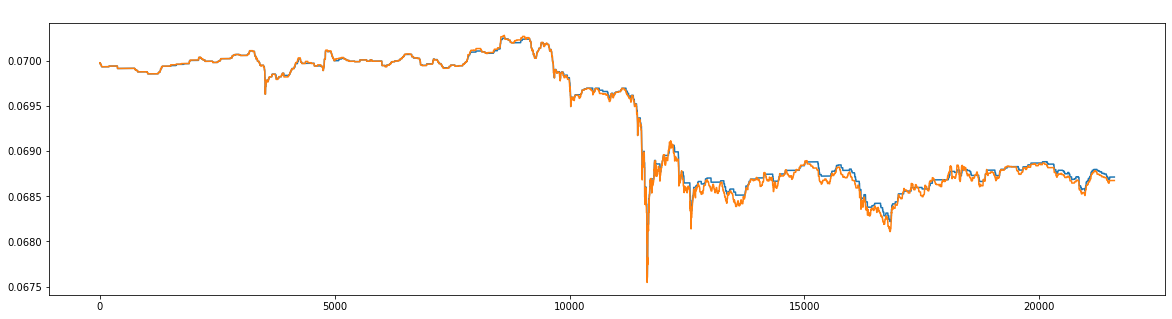

In [7]:
# for tkn in initial_state.pools['omnipool'].asset_list:
#     # print(tkn)
#     # plt.figure(figsize=(20, 5))
#     ax = pu.plot(events[100:], pool='omnipool', prop='price', key=tkn)
#     pu.plot(events2[100:], pool='omnipool', prop='price', key=tkn, subplot=ax)
#     # plt.title(tkn)

lrna_prices = [1/event['state'].pools['omnipool'].price("USD") for event in events[100:]]
lrna_prices2 = [1/event['state'].pools['omnipool'].price("USD") for event in events2[100:]]
ax = pu.plot(lrna_prices)
pu.plot(lrna_prices2, subplot=ax)

Text(0.5, 1.0, 'LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

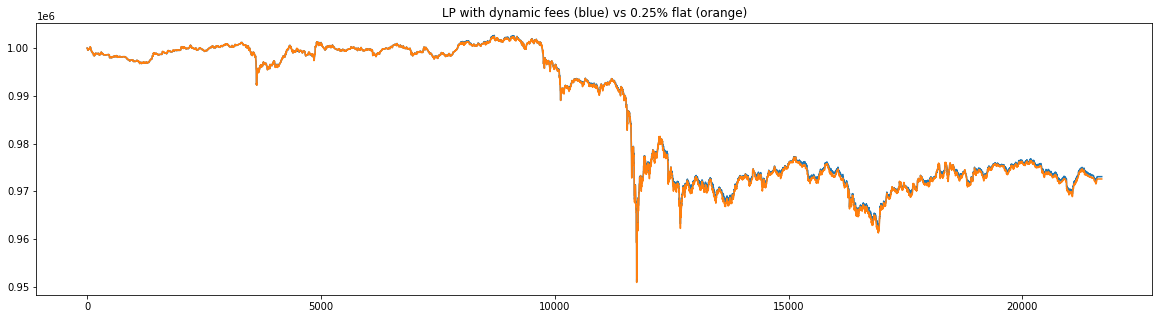

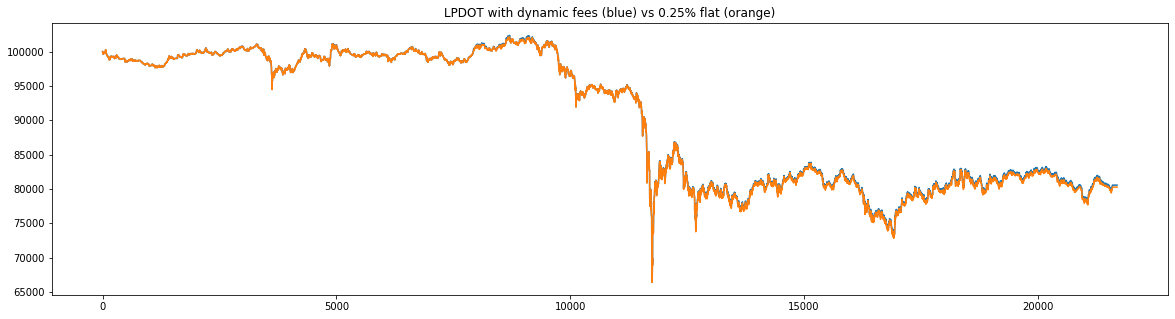

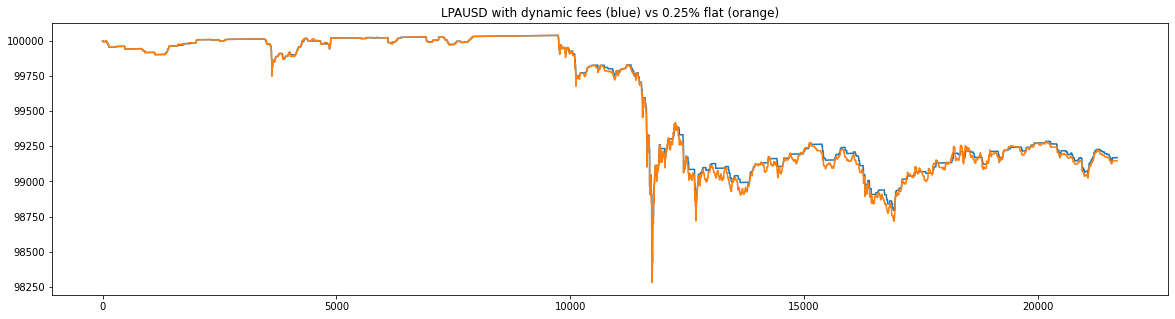

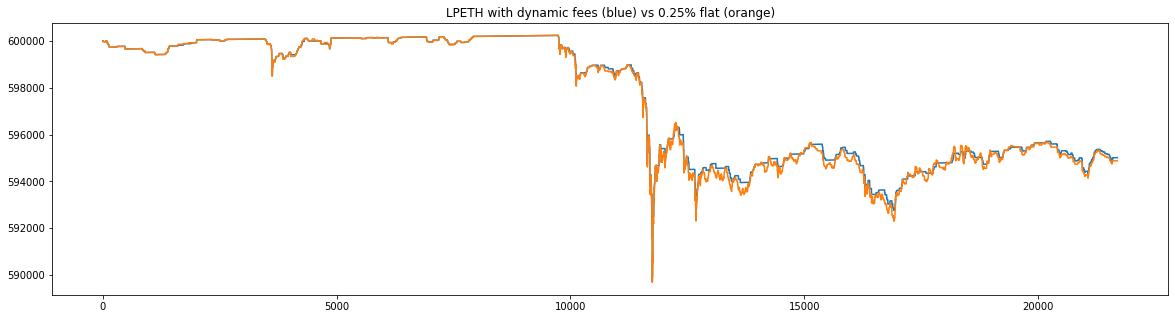

In [8]:
# lp_with_fees = pu.get_datastream(events, 'LP returns')
# lp_no_fees = pu.get_datastream(events2, 'LP returns')
# import cProfile, pstats
# profiler = cProfile.Profile()
# profiler.enable()

ax = pu.plot(events, agent='LP', prop='cash_out')
pu.plot(events2, agent='LP', prop='cash_out', subplot=ax)
plt.title('LP with dynamic fees (blue) vs 0.25% flat (orange)')





ax = pu.plot(events, agent='LPDOT', prop='cash_out')
pu.plot(events2, agent='LPDOT', prop='cash_out', subplot=ax)
plt.title('LPDOT with dynamic fees (blue) vs 0.25% flat (orange)')

# lp_cashout = state.cash_out(state.agents['LPDOT'])

ax = pu.plot(events, agent='LPAUSD', prop='cash_out')
pu.plot(events2, agent='LPAUSD', prop='cash_out', subplot=ax)
plt.title('LPAUSD with dynamic fees (blue) vs 0.25% flat (orange)')

ax = pu.plot(events, agent='LPETH', prop='cash_out')
pu.plot(events2, agent='LPETH', prop='cash_out', subplot=ax)
plt.title('LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

# profiler.disable()
# stats = pstats.Stats(profiler)
# stats.dump_stats('profile-data')



In [9]:
# lp_cashout = state.cash_out(state.agents['LPDOT'])


# lrna_imbalance = [event['state'].pools['omnipool'].lrna_imbalance for event in events]
pprint(events[0]['state'].cash_out(events[0]['state'].agents['LPAUSD']))
pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPAUSD']))
pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPAUSD']))
savings = events[-1]['state'].cash_out(events[-1]['state'].agents['LPAUSD']) - events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPAUSD'])
pprint(savings/events[0]['state'].cash_out(events[0]['state'].agents['LPAUSD']))

pprint(events[0]['state'].cash_out(events[0]['state'].agents['LPETH']))
pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPETH']))
pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPETH']))
savings = events[-1]['state'].cash_out(events[-1]['state'].agents['LPETH']) - events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPETH'])
pprint(savings/events[0]['state'].cash_out(events[0]['state'].agents['LPETH']))

mpf('99999.999999999999999999999999999999999999999999997548')
mpf('99169.076371807171627440272115853384158997722895539471')
mpf('99146.68440694757447358317247801995085326015202221085')
mpf('0.00022391964859597153857099637833433305737570873328622319')
mpf('600000.0000000000000000000000000000000000000000000028')
mpf('595014.45823084297315178667574138437827844125066992253')
mpf('594880.10644168550001397918206566241120893579835011617')
mpf('0.00022391964859578856301248945953661178250908719967726972')


In [10]:
# pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPDOT']))
init_omni = events[1]['state'].pools['omnipool']
final_omni = events[-1]['state'].pools['omnipool']
init_omni2 = events2[1]['state'].pools['omnipool']
final_omni2 = events2[-1]['state'].pools['omnipool']

pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPDOT']))
pprint(events[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
pprint(events[-1]['state'].agents['LPDOT'].share_prices[('omnipool', 'DOT')])
print(events[0]['state'].pools['omnipool'].price('DOT'))
print(events[-1]['state'].pools['omnipool'].price('DOT'))
print(events2[-1]['state'].pools['omnipool'].price('DOT'))
print(events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('USD'))
print(events[0]['state'].pools['omnipool'].price('DOT')/events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('DOT')/events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('DOT')/events2[-1]['state'].pools['omnipool'].price('USD'))
print(init_omni.liquidity['DOT'])
print(final_omni.liquidity['DOT'])
print(final_omni2.liquidity['DOT'])
print(init_omni.lrna['DOT'])
print(final_omni.lrna['DOT'])
print(final_omni2.lrna['DOT'])
print(init_omni.lrna_total)
print(final_omni.lrna_total)
print(final_omni2.lrna_total)
pprint(init_omni.lrna)
pprint(final_omni.lrna)
pprint(final_omni2.lrna)

pprint(events[0]['state'].agents['Arbitrageur'].holdings['LRNA'])
pprint(events[-1]['state'].agents['Arbitrageur'].holdings['LRNA'])
pprint(events2[-1]['state'].agents['Arbitrageur'].holdings['LRNA'])


# pprint(events2[0]['state'].agents['LPDOT'])
# pprint(events2[-1]['state'].agents['LPDOT'])
# pprint(events[0]['state'].agents['LPDOT'])
# pprint(events[-1]['state'].agents['LPDOT'])
# state.cash_out(state.agents['LPDOT'])


mpf('80549.215582737219577545736427798649350771904647773534')
mpf('2903.4316387885930444123823230685367700320655453756366')
mpf('492.02853454196046097542433926531412009057010264896132')
492.02853454196046097542433926531412009057010264896
402.0854478605503691448991073350878190036055847903
402.33451874898621174575779235534193306490262805937
14.285713214736668078965103316227168081118165435576
14.553143202276652804223154197287246655861788205604
14.561317095205137147057594727614257980567996510898
34.442000000000009729980307000726277908478459803867
27.628770106354017887010922718113633303688029858223
27.630365860343088512420685482031714970794361218266
34841.187066098671056211370368139064919884777973748
38772.627567781615656292360263788062446780355832398
38620.966524978865563388330165209328273705660760493
17142856.9286616146564483642578125
15589909.320321792695714673027396202087402343750008
15538547.980448078248136286371542761723200480143202
168571426.6436688117682933807373046875
168571426.643

In [11]:
# print(events[0], events[1000])

In [12]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LP']))

1000000.0000000000101444212287653378670971610221442
973070.90292900167906915661120004063874200584491428
972581.64564967474910887942841817547314756723336031


In [13]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LPDOT']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LPDOT']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LPDOT']))

100000.0000000000045933061056395551649790026816901
80549.215582737219577545736427798649350771904647774
80261.485987146524452993928836188461229278589454109


In [14]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LPAUSD']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LPAUSD']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LPAUSD']))

99999.999999999999999999999999999999999999999999998
99169.076371807171627440272115853384158997722895539
99146.684406947574473583172478019950853260152022211


In [15]:
print(events[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
print(events2[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
print(events[0]['state'].pools['omnipool'].price('DOT')/events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('DOT')/events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('DOT')/events2[-1]['state'].pools['omnipool'].price('USD'))
# print(events[-1]['state'].agents['LPAUSD'])

2903.4316387885930444123823230685367700320655453756
2903.4316387885930444123823230685367700320655453756
34.442000000000009729980307000726277908478459803867
27.628770106354017887010922718113633303688029858223
27.630365860343088512420685482031714970794361218266


<AxesSubplot:title={'center':'omnipool  price USD '}>

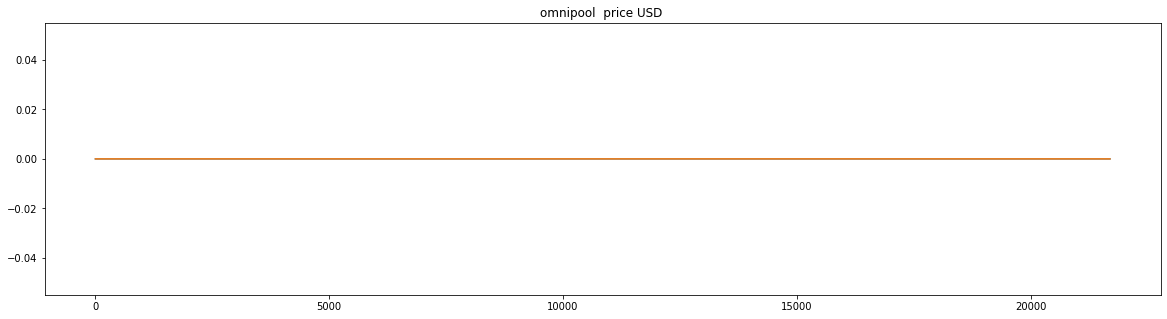

In [16]:
ax = pu.plot(events, pool='omnipool', prop='price', key='USD')
pu.plot(events2, pool='omnipool', prop='price', key='USD', subplot=ax)

In [17]:
final_pool1 = events[-1]['state'].pools['omnipool']
final_pool2 = events2[-1]['state'].pools['omnipool']
lrna_price1 = 1/events[-1]['state'].pools['omnipool'].price('USD')
print(lrna_price1)
lrna_price2 = 1/events2[-1]['state'].pools['omnipool'].price('USD')
print(lrna_price2)
total_lrna1 = sum(events[-1]['state'].pools['omnipool'].lrna[tkn] for tkn in events[-1]['state'].pools['omnipool'].asset_list)
print(total_lrna1)
total_lrna2 = sum(events2[-1]['state'].pools['omnipool'].lrna[tkn] for tkn in events2[-1]['state'].pools['omnipool'].asset_list)
print(total_lrna2)
print(lrna_price1*total_lrna1)
print(lrna_price2*total_lrna2)
print(final_pool1.lrna_imbalance) # dynamic fees cause us to burn a lot more LRNA!
print(final_pool2.lrna_imbalance)

0.068713678282473219369525594673436802160782565157134
0.068675106342494781349380654473545276142915326803611
168571426.64366970411595446523278951644897460937489
168571426.64367100272513873884842420617739359537763
11583162.778010654364730173756530977174626367913758
11576660.651060164251352452235823648521432734642906
0.0
0.0


In [18]:
print(initial_state)

global state 
pools: 

    Omnipool: omnipool
    ********************************
    tvl cap: inf
    lrna fee:
    
        HDX: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        USD: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        AUSD: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        ETH: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
        DOT: Dynamic LRNA fee (oracle=fee_raise, amplification=0.2, min=0.0005)
    
    asset fee:
    
        HDX: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        USD: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        AUSD: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        ETH: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
        DOT: Dynamic fee (oracle=fee_raise, amplification=1, min=0.0025)
    
    asset pools: (
    
        *HDX*
        asset quantity: 20000000.0
        lrn

In [19]:
pprint(events[0]['state'].pools['omnipool'].liquidity)
pprint(events[0]['state'].agents['Trader'].holdings)
pprint(events[-1]['state'].agents['Trader'].holdings)

{'AUSD': mpf('1200000.0749684384448916569927513545070857965037466855'),
 'DOT': mpf('34841.18445410947190698042638898663953950363860693588'),
 'ETH': mpf('7200000.4498106306693499419565081270425147790224798213'),
 'HDX': mpf('22000001.49936877150684104822799150172687412783096564'),
 'USD': mpf('1100000.0749684385753420524113995750863437063915482825')}
{'AUSD': mpf('999999999.92503156155510834300724864549291420349625367'),
 'DOT': mpf('999999999.99782334247590466130397915072007963698639323'),
 'ETH': mpf('999999999.5501893693306500580434918729574852209775206'),
 'HDX': mpf('999999998.50063123110216666455173879208350143623762859'),
 'LRNA': mpf('1000000000.0'),
 'R1': 1000000000,
 'R2': 3000000000,
 'USD': mpf('999999999.92503156155510833322758693960417507181188028')}
{'AUSD': mpf('999998029.27383047017031287903505153463997101308728437'),
 'DOT': mpf('999999798.74571501703996752721605715580147066344225621'),
 'ETH': mpf('999988175.6429828210206647297547306975825236385356508'),
 'HDX': mp